In [168]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models

from PIL import Image
from tqdm import tqdm
from torchvision import transforms, models, datasets

In [103]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [123]:
IMG_SIZE = 512
BATCH_SIZE = 16
lr = 1e-3
EPOCHS = 2

content_weight = 1e5
style_weight = 1e10
tv_weight = 1e-7

In [124]:
transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),  
    transforms.ToTensor()]) 

In [125]:
content = Image.open('in20.png')
style = Image.open('tar20.png')

In [126]:
content = transform(content).unsqueeze(0).to(device, torch.float)
style = transform(style).unsqueeze(0).to(device, torch.float)

In [127]:
content.size()

torch.Size([1, 3, 512, 769])

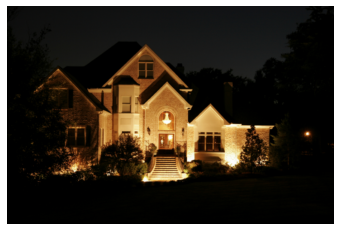

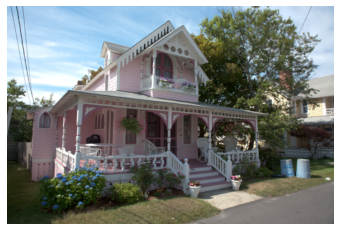

In [128]:
def imshow(tensor, title='Image'):
    image = tensor.cpu().clone()  
    image = transforms.ToPILImage()(image.squeeze(0))
    plt.imshow(image)
    plt.axis('off')


plt.figure()
imshow(style)

plt.figure()
imshow(content)

Сначала реализуем Loss Network, которую будем использовать в дальнейшем.

In [129]:
class LossNetwork(nn.Module):
    
    def __init__(self):
        super(LossNetwork, self).__init__()
        
        self.vgg_layers = models.vgg16(pretrained=True).features.eval()
        
        self.relu1_2 = self.vgg_layers[:4]
        self.relu2_2 = self.vgg_layers[4:9]
        self.relu3_3 = self.vgg_layers[9:16]
        self.relu4_3 = self.vgg_layers[16:23]
        
    def forward(self, x):
        
        out_1 = self.relu1_2(x)
        out_2 = self.relu2_2(out_1)
        out_3 = self.relu3_3(out_2)
        out_4 = self.relu4_3(out_3)
        
        out_names = ['relu1_2', 'relu2_2', 'relu3_3', 'relu4_3']
        out_list = [out_1, out_2, out_3, out_4]
        
        zip_out = zip(out_names, out_list)
        dict_out = dict(zip_out)
        
        return dict_out

In [132]:
class ResidualBlock(nn.Module):
    
    def __init__(self, number_channels):
        
        super(ResidualBlock, self).__init__()
        
        self.seq1 = nn.Sequential(
            nn.Conv2d(number_channels, number_channels, 3, stride=1, padding=1),
            nn.BatchNorm2d(number_channels),
            nn.ReLU(),        
        )
        
        self.seq2 = nn.Sequential(
            nn.Conv2d(number_channels, number_channels, 3, stride=1, padding=1),
            nn.BatchNorm2d(number_channels)        
        )
        
        
        
    def forward(self, img):
        
        x = self.seq1(img)
        x = self.seq2(x)
        x = F.relu(x + img)
        
        return x

In [133]:
class ImageTransformNet(nn.Module):
    
    def __init__(self):
        
        super(ImageTransformNet, self).__init__()
        
        self.pad = nn.ReflectionPad2d(40)
     
        self.conv = nn.Sequential(
            # block 1
            nn.Conv2d(3, 32, 9, stride=1, padding=4),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            # block 2
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            # block 3
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()          
        )
        
        self.residual = nn.Sequential(
            ResidualBlock(128), 
            ResidualBlock(128), 
            ResidualBlock(128), 
            ResidualBlock(128), 
            ResidualBlock(128)
        )
        
        self.upsampling = nn.Sequential(
            # block 1
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            # block 2
            nn.Upsample(scale_factor=2),
            nn.Conv2d(64, 32, 3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU()        
        )
        
        
        self.conv4 = nn.Conv2d(32, 3, 9, stride=1, padding=4)
        
        
        
    def forward(self, x):
#         x = self.pad(x)
        x = self.conv(x)
        
        x = self.residual(x)
        
        x = self.upsampling(x)
        x = self.conv4(x)
        x = torch.tanh(x)
        return x

In [159]:
def get_gram_matrix(m):
    b, ch, h, w = m.shape
    
    F = m.view(b, ch, w * h)
    F_t = F.transpose(1, 2)
    
    G = F.bmm(F_t) / (ch * h * w)
    return G

In [134]:
# обучаем сеть на картинках 256 на 256
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# используем датасет COCO 2017 val (в оригинальной статье используют COCO 2014 train)
train = datasets.ImageFolder('./Images/', transform=transform)
trainset = torch.utils.data.DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)

In [176]:
loss_net = LossNetwork()
transform_net = ImageTransformNet()

optimizer = torch.optim.Adam(transform_net.parameters(), lr)
mse_loss = nn.MSELoss()

In [177]:
features_style = loss_net(style)

# матрица грамма для каждой из 4 фичей: 'relu1_2', 'relu2_2', 'relu3_3', 'relu4_3'
gram_style = [get_gram_matrix(i) for i in features_style.values()]

In [192]:
for epoch in tqdm(range(EPOCHS)):
    
    for i, data in enumerate(trainset):

        optimizer.zero_grad()
        
        X, y = data
        batch_size = len(X)
        
        cur = transform_net(X)
        features_cur = loss_net(cur)
        features_x = loss_net(X)

        content_loss = F.mse_loss(features_cur['relu3_3'], features_x['relu3_3'])
        
        
        y_hat_gram = [get_gram_matrix(i) for i in features_cur.values()]
        style_loss = 0.0

        for j in range(4):
            style_loss += F.mse_loss(y_hat_gram[j], gram_style[j][:batch_size])


        tv_loss = torch.sum(torch.abs(cur[:, :, :, 1:] - cur[:, :, :, :-1]))
        tv_loss += torch.sum(torch.abs(cur[:, :, 1:, :] - cur[:, :, :-1, :]))
    

        total_loss = content_weight*content_loss + style_weight*style_loss + tv_weight*tv_loss
        total_loss.backward()

        optimizer.step()

        
        if i % 100 == 0 or i == 1:
            
            print(f"Epoch: {epoch}, iter: {i}, loss: {total_loss.item()}, "
                          f"style: {style_loss.item()},content: {content_loss.item()}, tv: {tv_loss}")